# Kernels define spaces of functions
- What makes a model "good" or "bad"? 
- Multivariate normal with a specific kernel "scores" how well a function is in that space
- different type of dot products

# Useful kernels
- ExpQuad
- Linear, polynomial
- Periodic
- Matern
- 1D, 2D, 3D

# Modeling using kernel rules
- Change the parameters, change the kernel functions
- Building kernels completely from scratch requires some more theory that we're going to skip over
  the most common way to make new kernels is to build them by combining existing kernels, instead of completely from scratch
- Adding and multiplying kernels
- Symmetries, circular kernel

# More useful kernels
- random walk kernel, spline kernel
- neural network kernel, autoregressive kernel
- kernels on strings, kernels on histograms

# Kernels demystified (THEORY SECTION)

Maybe have this, maybe not.

- the kernel trick
- feature space and function space
- bayesian linear regression
- inner products from regression features, linear kernel. https://stats.stackexchange.com/a/593451

# Intro

You can already do a lot with GPs using the kernel we've already seen, but there are many many more kernels out there -- and you can even design your own for the problem at hand!  Remember earlier when we said that GPs can be equivalent to linear or polynomial regression, autoregressive time series models, neural networks and many other statistical models?  All of these different methods may not seem super related, but they are all connected by kernels.  The particular choice of kernel is what make GPs equivalent to these different models. 

While that might be interesting theoretically, it's pretty useful practically too.  The takeaway is, if you're trying to represent some process you've been handed, a few simple kernels will get you pretty far.  This is where we'll focus.  But, you have a huge amount of freedom and flexibility available to you.  

Another thing to keep in mind is while this course is about GPs, kernels are everywhere!  What you're learning here will apply to things like support vector machines too. 

# Kernels define spaces of functions

Would you agree with the statement that there are an infinite number of numbers between 0 and 1?  You can slice that range of numbers finer and finer with no end.  Here is $\pi$ to 500 decimal places:

$$
3.14159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912
$$

It doesn't include whole numbers, like 178 or -2.  There's also an infinite number of numbers between 5 and 25, and clearly there's no overlap with the numbers between 0 and 1.  In fact, there is an infinite number of ways to group scalar numbers, into sets of infinite size!

Maybe this is interesting, or maybe it's kind of "sure, I guess so?"  But, if we go from scalars to functions, in a somewhat analogous way, we use GPs to put priors over different spaces of functions.  A kernel actually [can be used to define the space of functions](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space#:~:text=The%20Moore%E2%80%93Aronszajn%20theorem%20goes,Moore.). 

## The first kernel

In first lesson, you were introduced to your first kernel, the exponentiated quadratic:
$$
k(x, x' \,; \ell) = \exp\left( \frac{-(x - x')^2}{2\ell^2} \right)  
$$
Let's set $\ell=1$ and look again at some samples from the Gaussian process prior and follow them as the wind randomly through the prior space.  So these are 3 functions, and we're going to watch as they follow their random path.  We haven't fit anything to data yet, so these functions are just wandering randomly through the space defined by $k(x, x' \,; \ell=1)$.

MovieWriter ffmpeg unavailable; using Pillow instead.


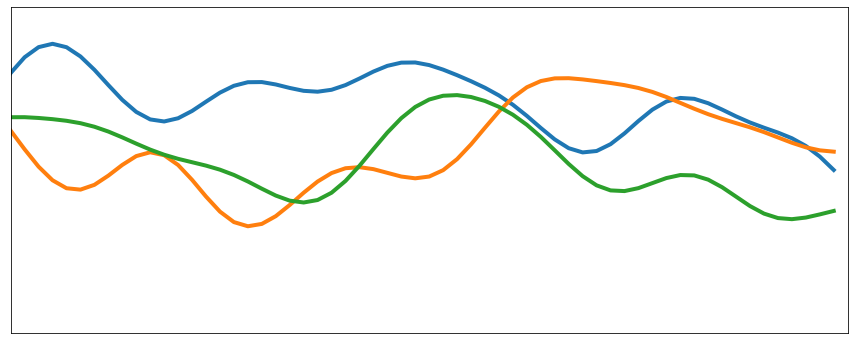

In [93]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


N = 400
x = np.linspace(0, 75, N)
kernel = pm.gp.cov.ExpQuad(1, ls=1)

samples = pm.draw(pm.MvNormal.dist(mu=np.zeros(N), cov=kernel(x[:, None])), 3)

fig, ax = plt.subplots(figsize=(15,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

lines = ax.plot(x, samples.T, lw=4)

def update(num, x, samples, lines):
    for i, line in enumerate(lines):
        line.set_data(x[:num], samples[i, :num])

        lb = np.min(samples)
        ub = np.max(samples)

        if num > 60:
            line.axes.axis([x[num-60], x[num], lb, ub])
        else:
            line.axes.axis([-0.01, x[num], lb, ub])

    return lines

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, samples, lines],
                              interval=75, blit=False)
ani.save('expquad1.gif')
plt.show()

What do we notice?
- functions are smooth, no jagged bumps
- they dont ever repeat, they just slowly bend and wander back eventually
- they dont wander off, they tend to come back and hover around some value

## The second kernel, Matern

This one is similar, but not quite the same.  This is the [Matern$^{\frac{5}{2}}$ kernel](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function), and it's arguably the best "default" kernel to use, because it's not quite as smooth as the exponentiated quadratic.  That extreme smoothness isn't always something the data demonstrates in practice.  Matern kernels are also very common in spatial applications.  The reason it's probably not the most commonly used is because its mathematical formula is a bit complicated.  That fact doesn't matter to us though, since it's also already implemented in PyMC.

Here is what samples from a GP with a Matern$^{\frac{5}{2}}$ kernel look like:

MovieWriter ffmpeg unavailable; using Pillow instead.


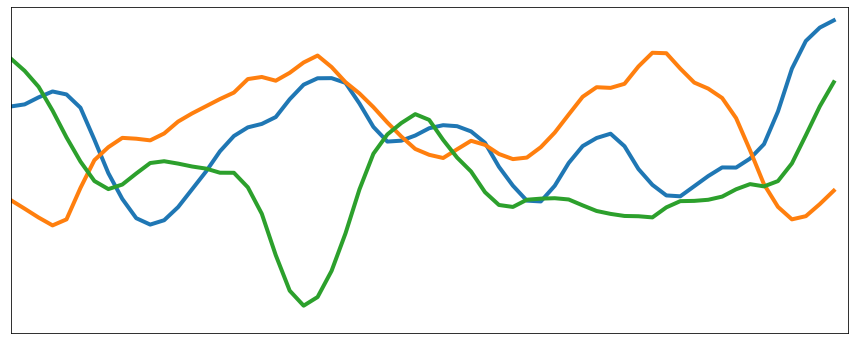

In [109]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


N = 400
x = np.linspace(0, 75, N)
kernel = pm.gp.cov.Matern52(1, ls=1)

samples = pm.draw(pm.MvNormal.dist(mu=np.zeros(N), cov=kernel(x[:, None])), 3)

fig, ax = plt.subplots(figsize=(15,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

lines = ax.plot(x, samples.T, lw=4)

def update(num, x, samples, lines):
    for i, line in enumerate(lines):
        line.set_data(x[:num], samples[i, :num])

        lb = np.min(samples)
        ub = np.max(samples)

        if num > 60:
            line.axes.axis([x[num-60], x[num], lb, ub])
        else:
            line.axes.axis([-0.01, x[num], lb, ub])

    return lines

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, samples, lines],
                              interval=75, blit=False)
ani.save('matern1.gif')
plt.show()

You can see that they're pretty similar to the exponentiated quadratic, but perhaps a bit "choppier".  Not quite as smooth.  But similarly, they don't repeat, and they also hover around the mean.

Let's reintroduce another kernel -- one that has markedly different behavior.  We used it in the Mauna Loa example already, but didn't talk about it at all.  This is the random walk kernel again.  Written in math it's

$$
k(x, x') = min(x, x')
$$

This is definitely a weird one.  The "similarity" measure here is just the minimum of $x$ and $x'$.  It's a strange way to represent a random walk, and we'll see in a bit that there are other, much simpler, ways to conceptualize it.  

Remember how we said before that there are kernels for neural networks and spline regressions too?  They usually have funny forms like this one. 

In [110]:
import aesara.tensor as at

class RandomWalk(pm.gp.cov.Covariance):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])

    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return at.minimum(X, at.transpose(Xs)) 

    def diag(self, X):
        return at.reshape(X, (-1, ))

MovieWriter ffmpeg unavailable; using Pillow instead.


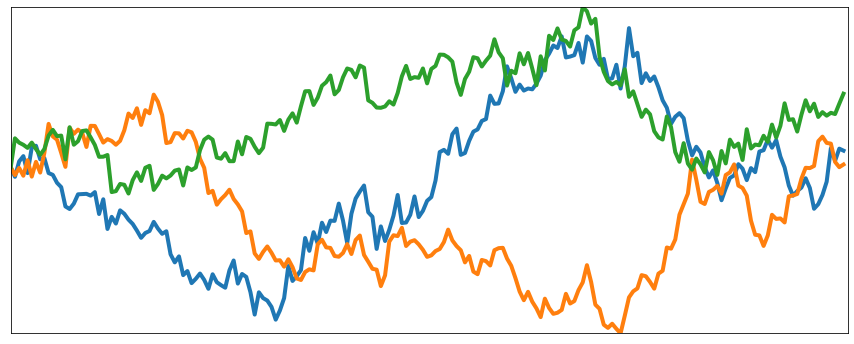

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


N = 200
x = np.arange(N)
kernel = RandomWalk()
samples = pm.draw(pm.MvNormal.dist(mu=np.zeros(N), cov=kernel(x[:, None])), 3)

fig, ax = plt.subplots(figsize=(15,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

lines = ax.plot(x, samples.T, lw=4)

def update(num, x, samples, lines):
    for i, line in enumerate(lines):
        line.set_data(x[:num], samples[i, :num])

        lb = np.min(samples)
        ub = np.max(samples)
        line.axes.axis([-0.01, x[num], lb, ub])

    return lines

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, samples, lines],
                              interval=75, blit=False)
ani.save('randomwalk1.gif')
plt.show()

This one played out quite a bit differently.  What did we notice here?
- All three samples started in the same place
- These functions aren't smooth.  They hop around quickly.  
- They don't seem to be heading back to some sort of middle value.  They look like they'll just drift randomly unconnected from anything, and that's right.

### Aside: Random walks

In case you're not familiar with the random walk process, it's pretty simple.  We don't need a kernel to simulate it.  In this case (and many others!) it's actually much easier to simulate without placing them inside the framework of Gaussian processes.  This is the mathematically definition of a random walk:

$$
x_t = \mathcal{N}(x_{t - 1}, \sigma^2) \,.
$$

Your next data point is your current datapoint plus some Gaussian random noise.  Many real world processes follow this sort of pattern.  Imagine trying to [model your weight over time (highly recommend this lecture!)](https://youtu.be/TR0LCVslIIM?t=2035), or, 

we can think about modeling the price of some financial asset like a stock or a house.  Imagine that in the simplest terms, the value of your house should largely stay constant.  But, if you improve something, like replacing the floors with something nicer, that would increase the value.  If you break something, like put a big dent in the wall carrying smoething awkward, that should decrease it's value, a tiny amount to be sure, but it's just a bit worse than it was before.  Over time, all the improvements and all the wear and tear are going to be bumping the value around and the final value would be the cumulative sum of the breaks, cracks, repairs, and improvements (ignoring larger market forces, [which may be described by random walks themselves](https://ryxcommar.com/2021/11/06/zillow-prophet-time-series-and-prices/)).  Although simple, a random walk is a fairly reasonable descriptor, or at least component of, house value. 

Here's a simulated Gaussian random walk $not$ in PyMC, just using Numpy.

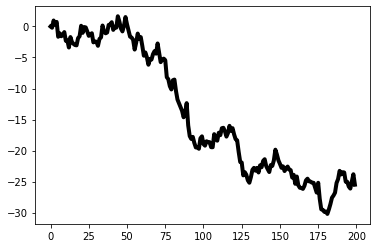

In [77]:
f = [0.0] # starting at zero
sigma = 0.1 # stepsize

for i in range(199): # 200 total points
    most_recent_f = f[-1]
    new_f = most_recent_f + np.random.randn()
    f.append(new_f)
    
plt.plot(f, color="k", lw=4);

Now let's do it in PyMC.  You can see there are two equivalent ways, using `at.cumsum` or using `pm.GaussianRandomWalk`.

In [119]:
with pm.Model() as model:
    #f0 = 0.0
    #f_steps = pm.Normal("f_steps", mu=0.0, sigma=1.0, size=199)
    #f = pm.Deterministic("f", at.cumsum(at.concatenate(([f0], f_steps))))
    f = pm.GaussianRandomWalk("f", mu=0.0, sigma=1.0, steps=199, init_dist=pm.DiracDelta.dist(c=0.0))
    
with model:
    idata = pm.sample_prior_predictive(samples=1)

In [120]:
f = idata.prior.f.stack(sample=['chain', 'draw']).values.flatten()

Lets embed the same process into the animation so you can visually compare:

MovieWriter ffmpeg unavailable; using Pillow instead.


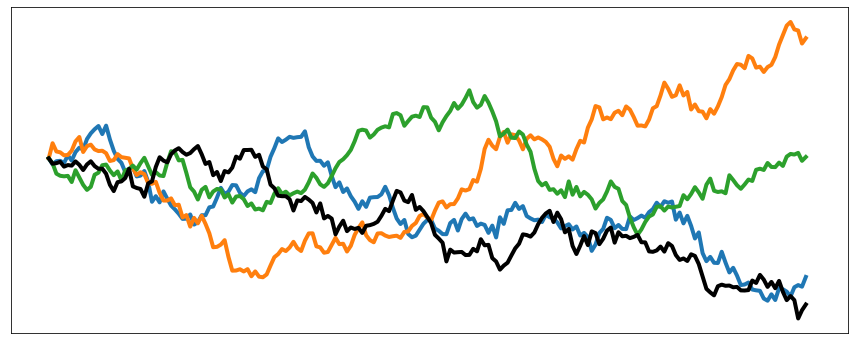

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


N = 200
x = np.arange(N)
kernel = RandomWalk()
samples = pm.draw(pm.MvNormal.dist(mu=np.zeros(N), cov=kernel(x[:, None])), 3)

fig, ax = plt.subplots(figsize=(15,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

lines = ax.plot(x, samples.T, lw=4)
black_line, = ax.plot(x, f, color="k", lw=4)
lines.append(black_line)

def update(num, x, samples, lines):
    
    # plot Gaussian process simulations
    for i in range(3):
        line = lines[i]
        line.set_data(x[:num], samples[i, :num])

        ub = np.max([np.max(samples), np.abs(np.min(samples))])
        lb = -ub
    
    # easy way to simulate a random walk
    lines[i + 1].set_data(x[:num], f[:num])

    return lines

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, samples, lines],
                              interval=75, blit=False)
ani.save('randomwalk2.gif')
plt.show()

### So which to use?

These are really just two equivalent -- but very different -- parameterizations of the same thing.  This is what it means to say that a random walk is just a special case of a Gaussian process.  Now that you know that, all the knowledge you have about GPs, now applies to random walks.

So, should you model your process using the Gaussian process parameterization, or the cumulative sum version we coded directly in PyMC?  The answer is, it depends.  The short answer is, if your model is *just* a random walk, or you're not us